# Real-time MRMS Visualization

This notebook helps you visualize real-time MRMS data etc.

---

## Overview
We'll go through the steps of:

1. Imports and formatting
2. Region selection
2. Product and tilt selection
3. Data request
4. Visualization

---

## Imports and formatting

Here are all required Python packages to run this code. 

In [1]:
import s3fs
import urllib
import tempfile
import gzip
import xarray as xr
import ipywidgets as widgets
import datetime
from datetime import timezone
import matplotlib.pyplot as plt
import numpy.ma as ma
from metpy.plots import ctables
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import hvplot.xarray 
import numpy as np
import numpy.ma as ma
from metpy.plots import ctables
import holoviews as hv
import matplotlib.colors as mcls
hv.extension('bokeh')

# Initialize the S3 filesystem as anonymous
aws = s3fs.S3FileSystem(anon=True)

# Retrieve the current datetime in UTC
now = datetime.datetime.now(datetime.UTC)
datestring = now.strftime('%Y%m%d')

## Region selection
This section can easily be hardcoded (e.g. by replacing this cell with <location = "CONUS">), but is left as a Python widget in this example to give the user flexibility to explore multiple regions. 

In [2]:
# Formatting settings for drop-down menus
style = {'description_width':'120px'}
layout = widgets.Layout(width='325px')  

# Dropdown widget to choose location from the options on AWS
location_choice = widgets.Dropdown(options=[("ALASKA"),("CARIB"),("CONUS"),("GUAM"),("HAWAII")], description='Region:', style=style, layout=layout)
location = location_choice.value
display(location_choice)

Dropdown(description='Region:', layout=Layout(width='325px'), options=('ALASKA', 'CARIB', 'CONUS', 'GUAM', 'HA…

In [3]:
# Retrieve the user selection from 'region' 
location = location_choice.value

## Data selection

There are numerous variables and tilts available from MRMS data. For reference, here https://www.nssl.noaa.gov/projects/mrms/operational/tables.php and here https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc

For the purpose of this notebook, I provide three options: 12-hour accumulated rainfall (with integrated rain gauge measurements), a merged reflectivitiy composite, and a model-derived surface temperature. All of these variables are taken from [AWS S3](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc) and can be cross-referenced from the [NSSL variable table](https://www.nssl.noaa.gov/projects/mrms/operational/tables.php) and Chapter 1 (link to first notebook). 

If you decide to use another product, you can search through [all available data products on AWS](https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/) and paste it in verbatim. 

In [4]:
products = ['LayerCompositeReflectivity_Low_00.50']

## Data request
We'll actually pull in the data here. 

In [5]:
# Container for data and metadata
product_data = {}

for product in products:
    # Query the S3 bucket for the available files that meet the criteria
    data_files = aws.ls(f'noaa-mrms-pds/{location}/{product}/{datestring}/', refresh=True)  
    if not data_files:
        continue

    # Choose the last file from S3 for the most recent data
    most_recent_file = data_files[-1]

    # Check that the most recent file is within 2 hours of current time
    timestamp_str = most_recent_file.split('_')[-1].replace('.grib2.gz', '')
    dt = datetime.datetime.strptime(timestamp_str, "%Y%m%d-%H%M%S").replace(tzinfo=timezone.utc)
    if abs((now - dt).total_seconds()) > 120 * 60:
        continue

    # Download file to memory, decompress from .gz, and read into xarray
    try:
        response = urllib.request.urlopen(f"https://noaa-mrms-pds.s3.amazonaws.com/{most_recent_file[14:]}")
        compressed_file = response.read()

        with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
            f.write(gzip.decompress(compressed_file))
            f.flush()
            data = xr.load_dataarray(f.name, engine="cfgrib", decode_timedelta=True)
    except Exception as e:
        print(f"Failed to process {product}: {e}")
        continue

    # Mask invalid/missing values
    vals = data.values
    masked_vals = ma.masked_where(vals <= 0, vals)

    # Store the data in the product_data dictionary
    product_data[product] = {
        'lats': data.latitude.values,
        'lons': data.longitude.values,
        'values': masked_vals,
        'time': dt,
    }

    data.close()

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(58) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(58) ignored


In [6]:
# Confirm the keys in product_data
product_data.keys()

dict_keys(['LayerCompositeReflectivity_Low_00.50'])

## Visualization
Let's see the results

<Figure size 640x480 with 0 Axes>

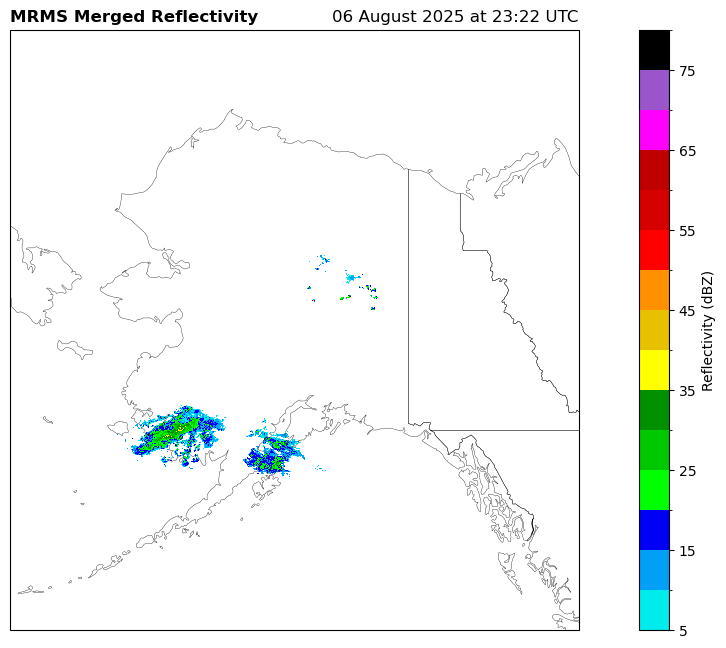

In [7]:
def plot_product(product):
    # Clear previous figure
    plt.clf()
    
    pdata = product_data[product]
    lons = pdata['lons']
    lats = pdata['lats']
    values = pdata['values']
    date = pdata['time']

    minLon = lons.min() 
    maxLon = lons.max()
    minLat = lats.min()
    maxLat = lats.max()

    fig = plt.figure(figsize=(12,6), facecolor='w', edgecolor='k')
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator())
    ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
    
    # Set colors
    if product == "LayerCompositeReflectivity_Low_00.50":
        ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)
        units = "Reflectivity (dBZ)"
        title = "MRMS Merged Reflectivity"
    if product == "GaugeInflIndex_12H_Pass1_00.00":
        ref_norm = None
        ref_cmap = "plasma"
        units = "RhoHV"
        title = "MRMS Gauge Infiltration Index"
    if product == "Model_SurfaceTemp_00.50":
        ref_norm = None
        ref_cmap = "viridis"
        units = "ZDR (dBZ)"
        title = "MRMS Merged Differential Reflectivity"
        
    # Add Boundaries
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

    # Plot Data
    radarplot = ax.pcolormesh(lons, lats, values, transform=ccrs.PlateCarree(),cmap=ref_cmap,norm=ref_norm)
    cbar = plt.colorbar(radarplot)
    cbar.set_label(units)

    plt.title(f"{title}", loc='left', fontweight='bold')
    plt.title('{}'.format(date.strftime('%d %B %Y at %H:%M UTC')), loc='right')

    plt.show()

plot_product('LayerCompositeReflectivity_Low_00.50')

Check this out and see if it's worth it: https://hvplot.holoviz.org/en/docs/latest/user_guide/Widgets.html

In [8]:
# This works well but is BIG. Going to think about space requirements before committing the output.
"""
# Use your reflectivity product from product_data
product = "LayerCompositeReflectivity_Low_00.50"

# Get the NWS Reflectivity colormap and normalize range
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

data = data.where(data > -50, np.nan)

# Convert to hex colors for Bokeh (required by hvplot)
from matplotlib.colors import Normalize
norm = Normalize(vmin=ref_norm.vmin, vmax=ref_norm.vmax)
hex_cmap = [ref_cmap(norm(val)) for val in range(ref_norm.vmin, ref_norm.vmax + 5, 5)]
hex_cmap = [mcls.to_hex(c) for c in hex_cmap]

# Plot using hvplot
reflectivity_plot = data.hvplot.image(
    x="longitude", y="latitude",
    cmap=hex_cmap,
    colorbar=True,
    geo=True, 
    tiles=True, 
    alpha=0.7,
    clim=(ref_norm.vmin, ref_norm.vmax),
    title=f"MRMS Reflectivity - {data.time.values}",
    frame_width=700,
    frame_height=500,
    xlabel='Longitude',
    ylabel='Latitude',
    tools=['hover']
)

reflectivity_plot
"""

'\n# Use your reflectivity product from product_data\nproduct = "LayerCompositeReflectivity_Low_00.50"\n\n# Get the NWS Reflectivity colormap and normalize range\nref_norm, ref_cmap = ctables.registry.get_with_steps(\'NWSReflectivity\', 5, 5)\n\ndata = data.where(data > -50, np.nan)\n\n# Convert to hex colors for Bokeh (required by hvplot)\nfrom matplotlib.colors import Normalize\nnorm = Normalize(vmin=ref_norm.vmin, vmax=ref_norm.vmax)\nhex_cmap = [ref_cmap(norm(val)) for val in range(ref_norm.vmin, ref_norm.vmax + 5, 5)]\nhex_cmap = [mcls.to_hex(c) for c in hex_cmap]\n\n# Plot using hvplot\nreflectivity_plot = data.hvplot.image(\n    x="longitude", y="latitude",\n    cmap=hex_cmap,\n    colorbar=True,\n    geo=True, \n    tiles=True, \n    alpha=0.7,\n    clim=(ref_norm.vmin, ref_norm.vmax),\n    title=f"MRMS Reflectivity - {data.time.values}",\n    frame_width=700,\n    frame_height=500,\n    xlabel=\'Longitude\',\n    ylabel=\'Latitude\',\n    tools=[\'hover\']\n)\n\nreflectivity_p